In [1]:
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc
#!pip install dvc --ignore-installed
!pip install --upgrade oauth2client
!pip install -r requirements.txt

  Using cached CFEDemands-0.2.7-py2.py3-none-any.whl (36 kB)
  Using cached dvc-2.0.17-py2.py3-none-any.whl (629 kB)
  Using cached ply-3.11-py2.py3-none-any.whl (49 kB)
  Using cached GitPython-3.1.14-py3-none-any.whl (159 kB)
Processing /home/jovyan/.cache/pip/wheels/34/2a/24/a490264ae9041fd48f778ff393526572c80bb498ddecb07ea5/configobj-5.0.6-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/0f/1b/ca/6263a5227f886599039aee3eed13951a6d44a02ee989ed6eb6/dpath-2.0.1-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/f4/f4/20/d7114a2d97a2e72ce7189a7f63a6fbd2a33ec6ae6010befca5/flufl.lock-3.2-py3-none-any.whl
  Using cached pathspec-0.8.1-py2.py3-none-any.whl (28 kB)
  Using cached voluptuous-0.12.1-py3-none-any.whl (29 kB)
  Using cached zc.lockfile-2.0-py2.py3-none-any.whl (9.7 kB)
  Using cached pygit2-1.5.0-cp38-cp38-manylinux2014_x86_64.whl (3.1 MB)
  Using cached dulwich-0.20.21-cp38-cp38-manylinux2010_x86_64.whl (516 kB)
  Using cached fsspec-0.9.0-py3-none-any.whl (1

  Created wheel for ftfy: filename=ftfy-6.0-py3-none-any.whl size=41622 sha256=97315eaf2209ad09ce9a2eabb75eb9933b6ed04f20522cdc9c59ed586f08ed76
  Stored in directory: /home/jovyan/.cache/pip/wheels/6e/94/84/52f0523a13dc8c2d5bd2b744386f91e134c5efb2b86998bbc2
Successfully built ftfy
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)
  Using cached numpy-1.19.2-cp38-cp38-manylinux2010_x86_64.whl (14.5 MB)
  Using cached pandas-1.1.3-cp38-cp38-manylinux1_x86_64.whl (9.3 MB)
  Using cached requests-2.25.0-py2.py3-none-any.whl (61 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.0
    Uninstalling pandas-1.2.0:
      Successfully uninstalled pandas-1.2.0
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled req

In [2]:
import pandas as pd

# set dataframes to show float values without exponential
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## (#A) Estimate Demand System

Estimate a system of demands for different kinds of food. Characterize how consumption varies with household need.

Retrieve data from google sheets using private keys:

In [3]:
import pandas as pd
import numpy as np
from eep153_tools import read_sheets

#Nigeria consumption (own production) dataset
Nigeria_Data = '17L5cDhXRLNAckP3JvBLTLSYIguFqP2ebMvQLH96c0n4'

#### Need private keys from json file (we're authenticating using "service accounts")
!gpg --batch --passphrase "noodle octopus" -d ./students-9093fa174318.json.gpg > ./students-9093fa174318.json
####

# Add credentials if sheet not meant to be public
exp_df = read_sheets(Nigeria_Data,sheet='Expenditures',json_creds='./students-9093fa174318.json')
                 
# Change 'ICRISAT' to key of your own sheet in Sheets, above
household_df = read_sheets(Nigeria_Data,sheet="HH Characteristics",json_creds='./students-9093fa174318.json')

# # Assume a single market by setting m = 1 for all
exp_df.insert(loc=2, column='m', value=1)
household_df.insert(loc=2, column='m', value=1)

household_df2 = household_df.copy().set_index(['t', 'j', 'm'])

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


### Data Cleaning and filter data by our chosen population (below poverty line)

In [4]:
exp_df = exp_df.replace(0,np.nan) # Replace zeroes with np.nan

#Convert all value types to float64
for i in range(3, len(exp_df.columns)):
    exp_df.iloc[:, i:] = exp_df.iloc[:, i:].astype('float64')
    
exp_df = exp_df.replace(0.0,np.nan) # Replace zeroes with np.nan

#### Create total expenditure column and filter expenditure dataframe by our condition

We create a new column 'Total expenditure' so we can filter households that have total food spendings under or at poverty line.

In [5]:
exp_df['Total expenditure'] = exp_df.iloc[:, 3:].sum(axis=1)
pd.DataFrame(exp_df['Total expenditure'])

,Total expenditure
0,20225.000
1,15365.000
2,4675.000
3,4465.000
4,7565.000
...,...
19136,31100.000
19137,6410.000
19138,20540.000
19139,22650.000


#### Poverty Line Dataframe (Households with food spendings under or equal to poverty line)

In [6]:
#87.8 thousand Naira food spending per year
#1688.46 per week
wk_poverty_line = 87800/52

poverty_line_df = exp_df[exp_df['Total expenditure'] <= wk_poverty_line]
poverty_line_df

,t,j,m,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,...,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots,Total expenditure
25,2010,10028,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,100.000,nan,nan,nan,nan,nan,nan,1210.000
56,2010,10059,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,120.000,1010.000
60,2010,10063,1,nan,nan,nan,nan,nan,nan,nan,...,nan,35.000,100.000,nan,nan,nan,nan,nan,nan,1365.000
66,2010,10069,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,100.000,nan,nan,nan,nan,nan,300.000,1050.000
72,2010,10075,1,nan,nan,nan,nan,nan,nan,nan,...,30.000,nan,100.000,nan,nan,60.000,nan,nan,nan,1450.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2018,379085,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,450.000,nan,nan,nan,1240.000
19103,2018,379090,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,200.000,nan,nan,nan,nan,nan,nan,1200.000
19104,2018,379091,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,1400.000
19105,2018,379092,1,nan,nan,nan,nan,nan,nan,nan,...,50.000,nan,nan,nan,nan,nan,nan,nan,nan,1190.000


In [7]:
#remove total expenditure column from calculation
poverty_line_df = poverty_line_df.drop(columns=['Total expenditure']) 
# poverty_line_df.set_index(['j', 't', 'm'])
poverty_line_df

,t,j,m,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,...,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots
25,2010,10028,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,100.000,nan,nan,nan,nan,nan,nan
56,2010,10059,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,120.000
60,2010,10063,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,35.000,100.000,nan,nan,nan,nan,nan,nan
66,2010,10069,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,100.000,nan,nan,nan,nan,nan,300.000
72,2010,10075,1,nan,nan,nan,nan,nan,nan,nan,...,nan,30.000,nan,100.000,nan,nan,60.000,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2018,379085,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,450.000,nan,nan,nan
19103,2018,379090,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,200.000,nan,nan,nan,nan,nan,nan
19104,2018,379091,1,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
19105,2018,379092,1,nan,nan,nan,nan,nan,nan,nan,...,nan,50.000,nan,nan,nan,nan,nan,nan,nan,nan


#### Filter household_df to include those only at or below poverty_line:

In [8]:
# filter households to those only at or below poverty line
idx_selected_households = poverty_line_df.index.tolist()
household_df = household_df[household_df.index.isin(idx_selected_households)]
household_df

,j,t,m,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+
25,10028,2010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
56,10059,2010,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
60,10063,2010,1,0,0,0,0,3,0,1,0,0,0,0,0,0,1
66,10069,2010,1,0,0,0,0,1,0,0,0,0,1,1,3,0,1
72,10075,2010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,369003,2018,1,0,0,0,0,0,1,0,1,2,1,0,1,0,0
19103,369007,2018,1,0,1,1,1,0,1,0,0,0,0,0,0,1,0
19104,369008,2018,1,0,0,1,0,0,0,1,0,0,0,0,0,0,2
19105,369025,2018,1,0,1,0,1,0,0,2,0,0,2,0,0,1,1


#### Logged Food Expenditure Dataframe (after running np.log on values)

In [9]:
# Take logs of expenditures of our selected population and name it log_poverty_line_df
log_poverty_line_df = np.log(poverty_line_df.set_index(['j', 't', 'm']))
log_poverty_line_df

,,,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,Beef,Beer (local and imported),Biscuits,...,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots
j,t,m,,,,,,,,,,,,,,,,,,,,,
10028,2010,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,4.605,nan,nan,nan,nan,nan,nan
10059,2010,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.787
10063,2010,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,3.555,4.605,nan,nan,nan,nan,nan,nan
10069,2010,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,4.605,nan,nan,nan,nan,nan,5.704
10075,2010,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,3.401,nan,4.605,nan,nan,4.094,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379085,2018,1,nan,nan,nan,nan,nan,nan,nan,5.011,nan,nan,...,nan,nan,nan,nan,nan,nan,6.109,nan,nan,nan
379090,2018,1,nan,nan,nan,nan,nan,nan,nan,6.215,nan,nan,...,nan,nan,nan,5.298,nan,nan,nan,nan,nan,nan
379091,2018,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


#### Add 'log Hsize' column to household_df:

In [10]:
# set index to j, t, m so that df.sum() ignore index values
household_df.set_index(['j','t','m'], inplace=True)

# create new column of household size
household_df['Hsize'] = household_df.sum(axis=1).values

# remove erroneous data with household_size = 0
household_df = household_df[household_df['Hsize'] > 0]

# create new column 'log Hsize'
household_df['log Hsize'] = np.log(household_df['Hsize'])

# remove Hsize column
household_df = household_df.drop(columns=['Hsize']) 

#### Household Characteristic Table (Only includes households at/below poverty line)

In [11]:
household_df

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,log Hsize
j,t,m,,,,,,,,,,,,,,,
10028,2010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000
10059,2010,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.000
10063,2010,1,0,0,0,0,3,0,1,0,0,0,0,0,0,1,1.609
10069,2010,1,0,0,0,0,1,0,0,0,0,1,1,3,0,1,1.946
10075,2010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369003,2018,1,0,0,0,0,0,1,0,1,2,1,0,1,0,0,1.792
369007,2018,1,0,1,1,1,0,1,0,0,0,0,0,0,1,0,1.609
369008,2018,1,0,0,1,0,0,0,1,0,0,0,0,0,0,2,1.386


### Estimation



With nothing more than this, we can estimate the demand system.  This
happens in two steps.  The first is the &ldquo;reduced form&rdquo; step:



In [12]:
import cfe

#regressand y is food expenditures (np.logged) by our selected population
#regressor z is household demographics

result = cfe.Result(y=log_poverty_line_df,z=household_df, min_xproducts=15, min_proportion_items=0.05)

This creates a complicated &ldquo;Result&rdquo; object, with lots of different
attributes.  Note from below that attributes $y$ and $z$ are now defined.



In [13]:
result

<xarray.Result>
Dimensions:           (i: 19, j: 3914, k: 15, m: 1, t: 4)
Coordinates:
  * j                 (j) int64 10002 10003 10004 10008 ... 379063 379066 379091
  * m                 (m) int64 1
  * t                 (t) int64 2010 2012 2015 2018
  * i                 (i) <U36 'Beef' 'Bread' ... 'White beans' 'Yam-roots'
  * k                 (k) <U9 'M 0-3' 'M 4-8' 'M 9-13' ... 'F 51+' 'log Hsize'
Data variables:
    alpha             object None
    beta              object None
    delta             object None
    prices            object None
    characteristics   (k, j, t, m) float64 nan 0.0 nan nan ... nan nan nan nan
    loglambdas        object None
    a                 object None
    yhat              object None
    ce                object None
    cehat             object None
    e                 object None
    delta_covariance  object None
    beta_covariance   object None
    se_delta          object None
    se_beta           object None
    se_alpha          object None
    se_a              object None
    y                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    logp              object None
    z                 (k, j, t, m) float64 nan 0.0 nan nan ... nan nan nan nan
Attributes:
    firstround:            2010
    min_proportion_items:  0.05
    min_xproducts:         15
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    verbose:               False

In [14]:
# result.get_loglambdas(as_df=True).quantile(0.8)

### First step of Estimation



Recall that there are two steps to estimation; the first step
involves estimating the &ldquo;reduced form&rdquo; linear regression 
$$
y_{it}^j = {a}_{it} + \delta_i'{z}^j_t + \epsilon_{it}^j.
$$

The Result class has code to estimate this in one line:



In [15]:
result.get_reduced_form()

/opt/conda/lib/python3.8/site-packages/cfe/estimation.py:367: UserWarning: No variation in: (2018, 1)
  warnings.warn("No variation in: %s" % str(constant))


After running this we can examine the estimated coefficients $\delta$:



In [16]:
result.delta.to_dataframe().unstack('k')

delta                                 \
k                                     F 0-3 F 14-18 F 19-30 F 31-50  F 4-8   
i                                                                            
Beef                                 -0.341   0.704   0.456   0.283  0.143   
Bread                                -0.210   0.385   0.138   0.154  0.102   
Chocolate drinks                     -0.021  -0.211  -0.007   0.778 -0.228   
Condiments,(salt,spices,pepper, etc) -0.081   0.098  -0.197  -0.108 -0.016   
Fish-Dried                           -0.251  -0.065   0.532   0.356 -0.089   
Fish-Frozen                           0.071  -0.116  -0.051  -0.049  0.163   
Fish-Smoked                          -0.298   0.461   0.020  -0.060  0.117   
Gari-White                           -0.015  -0.297  -0.668  -0.305  0.121   
Okra-fresh                            0.187  -0.151   0.099   0.249 -0.097   
Onions                                0.064   0.033   0.052   0.004 -0.035   
Other vegetables (fresh or canned)   -0.139  -0.215  -0.571  -0.391 -0.145   
Palm oil                             -0.037  -0.127  -0.062   0.040  0.026   
Rice-local                            0.054   0.003  -0.097   0.113 -0.173   
Sachet water                         -0.375  -0.256   0.319   0.073 -0.262   
Sugar                                -0.117  -0.155  -0.180  -0.023  0.035   
Tomato puree(canned)                  0.028   0.141   0.290   0.185  0.145   
Tomatoes                             -0.023  -0.051   0.022   0.035 -0.014   
White beans                          -0.009  -0.045  -0.159  -0.107 -0.067   
Yam-roots                             1.379  -0.709  -0.443   0.119  0.607   

                                                                           \
k                                     F 51+ F 9-13  M 0-3 M 14-18 M 19-30   
i                                                                           
Beef                                  0.242  0.183  0.564  -0.047   0.014   
Bread                                 0.047 -0.003  0.043  -0.030   0.091   
Chocolate drinks                      0.329  0.403  0.810  -0.203   0.903   
Condiments,(salt,spices,pepper, etc) -0.109 -0.064 -0.268  -0.185  -0.178   
Fish-Dried                            0.071  0.211 -0.205  -0.019  -0.194   
Fish-Frozen                          -0.222 -0.201 -0.147   0.017  -0.002   
Fish-Smoked                          -0.179 -0.098 -0.110  -0.170   0.139   
Gari-White                           -0.341 -0.319  0.251   0.128  -0.262   
Okra-fresh                            0.234  0.088  0.026  -0.041   0.034   
Onions                               -0.098  0.014 -0.063  -0.045   0.001   
Other vegetables (fresh or canned)   -0.215  0.358 -0.247  -0.356  -0.011   
Palm oil                             -0.104 -0.047  0.014  -0.128  -0.083   
Rice-local                           -0.012 -0.036 -0.186   0.128  -0.113   
Sachet water                         -0.204 -0.020  0.695  -0.439  -0.291   
Sugar                                -0.222  0.152  0.115  -0.163   0.133   
Tomato puree(canned)                  0.267  0.429  0.231  -0.097   0.122   
Tomatoes                              0.010  0.008 -0.213  -0.187   0.009   
White beans                          -0.149 -0.090 -0.054   0.078  -0.078   
Yam-roots                            -0.062 -0.389 -0.199   0.856  -0.024   

                                                                             
k                                    M 31-50  M 4-8  M 51+ M 9-13 log Hsize  
i                                                                            
Beef                                   0.303  0.035  0.257 -0.040    -0.478  
Bread                                  0.267  0.024  0.102 -0.054    -0.035  
Chocolate drinks                       0.442  0.514  0.205 -0.422    -0.206  
Condiments,(salt,spices,pepper, etc)  -0.255 -0.074 -0.330  0.028     0.674  
Fish-Dried                             0.111 -0.012  0.154  0.320    -0.197  
Fi

Also the good-time constants $a_{it}$ (this captures the effects of prices)<br>
i.e. differences in year and alpha coefficient


In [17]:
result.a.to_dataframe().unstack('i')

a                                                              \
i       Beef Bread Chocolate drinks Condiments,(salt,spices,pepper, etc)   
t    m                                                                     
2010 1 5.437 4.574            3.527                                3.183   
2012 1 5.449 4.482            3.580                                3.549   
2015 1 5.875 4.848            3.527                                3.703   
2018 1 5.525 4.627            4.048                                3.999   

                                                                        \
i      Fish-Dried Fish-Frozen Fish-Smoked Gari-White Okra-fresh Onions   
t    m                                                                   
2010 1      5.205       5.476       5.095      4.982      3.509  3.629   
2012 1      5.762       5.664       5.256      4.929      3.651  3.452   
2015 1      5.533       5.796       5.912      4.996      3.805  3.748   
2018 1      5.399       5.579       5.305      4.804      4.025  4.006   

                                                                            \
i      Other vegetables (fresh or canned) Palm oil Rice-local Sachet water   
t    m                                                                       
2010 1                              4.221    4.920      4.799        3.772   
2012 1                              4.056    4.846      4.873        3.608   
2015 1                              4.176    4.967      5.084        4.202   
2018 1                                nan    5.058      5.042        3.352   

                                                                  
i      Sugar Tomato puree(canned) Tomatoes White beans Yam-roots  
t    m                                                            
2010 1 3.559                3.554    3.999       4.628     5.266  
2012 1 3.677                3.772    4.159       4.953     5.380  
2015 1 3.775                4.086    4.327       4.871     6.552  
2018 1 3.509                3.918    4.208       5.161     5.558

### Second step of Estimation



The second step involves using Singular Value Decomposition to find
the rank one matrix that best approximates the residuals $e_{it}^j$.
This can be interpreted as
$$
    -\beta_i\log\lambda^j_t,
$$
where the $\log\lambda^j_t$ is the log of the marginal utility of
expenditures (MUE) for household $j$ at time $t$, and where $\beta_i$ are
the corresponding &ldquo;Frisch elasticities&rdquo; that tell us how much
demand changes as the MUE falls.

Estimates can also be computed as a one-liner:



In [18]:
result.get_beta(as_df=True)

i
Beef                                     nan
Bread                                  0.185
Chocolate drinks                         nan
Condiments,(salt,spices,pepper, etc)   0.838
Fish-Dried                               nan
Fish-Frozen                            0.359
Fish-Smoked                            0.164
Gari-White                               nan
Okra-fresh                             0.350
Onions                                 0.442
Other vegetables (fresh or canned)       nan
Palm oil                               0.236
Rice-local                             0.035
Sachet water                             nan
Sugar                                  0.739
Tomato puree(canned)                   0.091
Tomatoes                               0.225
White beans                            0.210
Yam-roots                                nan
Name: beta, dtype: float64

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.  (This can be controlled using the
`min_proportion_items` and `min_xproducts` attributes when one
instantiates the result object.)



### Assessment of Fit



Now, let&rsquo;s see how we did, by comparing total expenditures predicted by the
model we&rsquo;ve estimated with actual total expenditures:



/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


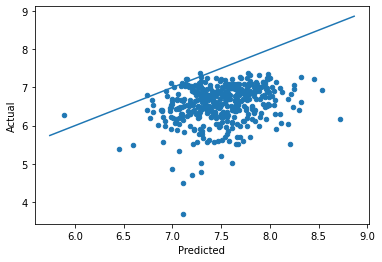

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

## (B) Nutritional content of different foods

For all the foods you're considering you'll need to be able to describe their nutritional content, in terms that allow you to compare with recommended daily allowances.

#### Load in Nigeria Consumption dataframe:

In [20]:
import pandas as pd
import numpy as np
from eep153_tools import read_sheets

url = '1kG_fVBmj9EEF9LOwxN30HBxkQENOoWeQjVPYzMJe3b4'

#### Need private keys from json file (we're authenticating using "service accounts")
!gpg --batch --passphrase "noodle octopus" -d ./students-9093fa174318.json.gpg > ./students-9093fa174318.json
####

# Add credentials if sheet not meant to be public
consumption_df = read_sheets(key=url ,sheet='Consumption',json_creds='./students-9093fa174318.json')

# Consider consumption of only those in our selected households
consumption_df.insert(loc=2, column='m', value=1)

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


In [21]:
selected_household_ids = exp_df.index.tolist()
selected_household_ids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [22]:
# remove erraneous column 'Canned'
consumption_df = consumption_df.drop(columns=['Canned'])

consumption_df = consumption_df[consumption_df.index.isin(selected_household_ids)]
consumption_df

,t,j,m,u,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,...,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots
0,2010,10001,1,Kilograms,nan,0.890,nan,nan,nan,nan,...,1.500,nan,0.420,1.000,nan,nan,3.000,nan,nan,16.000
1,2010,10001,1,Litres,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2010,10002,1,Kilograms,nan,0.890,nan,nan,nan,nan,...,1.800,0.120,0.560,1.000,nan,nan,2.000,nan,nan,13.800
3,2010,10002,1,Litres,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,2010,10003,1,Kilograms,nan,0.440,nan,nan,nan,nan,...,1.400,0.300,0.210,1.000,nan,nan,0.600,nan,nan,4.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19136,2012,190123,1,kilogram (kg),nan,nan,nan,nan,nan,nan,...,nan,nan,nan,2.000,nan,nan,nan,nan,nan,2.000
19137,2012,190124,1,centilitre (cl),nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
19138,2012,190124,1,grams (g),nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
19139,2012,190124,1,kilogram (kg),nan,nan,nan,nan,nan,nan,...,nan,nan,nan,2.000,nan,nan,nan,nan,nan,nan


#### Loading in fdc_codes from google sheets:

In [23]:
# File with private keys for relevant service account to authenticate
# and access google spreadsheets
!gpg --batch --passphrase "casimir" -d project3-key.json.gpg > project3-key.json

serviceacct = {'project2-casimir-funk':'project3-key.json'}
sheet_url = "https://docs.google.com/spreadsheets/d/1O0nHroRtnzBKSZXVWlqdTLIX16n5gg8aVBPcTjvLFKo/edit#gid=0"
sheet_name = 'Codes'

# Add credentials if sheet not meant to be public
fdc_code_df = read_sheets(key=sheet_url, json_creds=serviceacct["project2-casimir-funk"], sheet=sheet_name)
fdc_code_df

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


,Food description,USDA FDC ID,Kilograms/Litres
0,Pawpaw,1687869,0.100
1,Sheabutter,474641,0.100
2,Watermelon,1620656,0.100
3,Biscuits,477478,0.100
4,Buns/PofPof/Donuts,444979,0.100
...,...,...,...
127,Beer (local and imported),1104393,0.100
128,Palm wine,173185,0.100
129,Pito,1104393,0.100
130,Gin,1104487,0.100


In [24]:
#list of foods consumed:
fdc_food_items = fdc_code_df['Food description'].tolist()
fdc_food_items

['Pawpaw',
 'Sheabutter',
 'Watermelon',
 'Biscuits',
 'Buns/PofPof/Donuts',
 'Cake',
 'Cashew nut',
 'Cassava-Roots',
 'Cheese (wara)',
 'Ogbonno grinded',
 'Ogbonno ungrinded',
 'Meat pie/Sausage roll',
 'Guava',
 'Kola nut',
 'Coconut',
 'Coconut oil',
 'Dry pepper',
 'Fruit juice canned',
 'Grinded pepper',
 'Apples',
 'Groundnuts (shelled)',
 'Groundnuts (unshelled)',
 'Fresh pepper',
 'Maize (off the cob/grains)',
 'Maize (on the cob)',
 'Maize (shelled/off the cob)',
 'Maize (shelled/on the cob)',
 'Maize (unshelled/on the cob)',
 'Maize shelled',
 'Melon (ground)',
 'Chocolate drinks',
 'Guinea Corn/Sorghum',
 'Millet',
 'Maize',
 'Rice-local',
 'Rice-Imported',
 'Bread',
 'Maize flour',
 'Yam flour',
 'Cassava flour',
 'Wheat flour',
 'Other grains and flour',
 'Cassava-roots',
 'Yam-roots',
 'Gari-White',
 'Gari -Yellow',
 'Cocoyam',
 'Plantains',
 'Sweet Potatoes',
 'Potatoes',
 'Other roots and tuber',
 'Soya beans',
 'Brown beans',
 'White beans',
 'Groundnuts',
 'Other nu

In [25]:
#example: accessing fdc code from the dataframe
f = fdc_food_items[29]
fdc_id = int(fdc_code_df[fdc_code_df['Food description'] == f]['USDA FDC ID'].values[0])
fdc_id

746770

In [26]:
import fooddatacentral as fdc

# API key for FDC
apikey = "V0mOAdVrSineT4d2VTMTJUNPAsBTnjzUAU6e6H6V" # inIyO1begWSRqsYtxS7m6p09PSyq7Qiw7fxzV2qN"


# Query to fdc and get dataframe containing nutritional data of foods using their fdc_ids
food_to_nutrients = {}
for f in fdc_food_items:
    fdc_id = fdc_code_df[fdc_code_df['Food description'] == f]['USDA FDC ID'].values[0]
    if not np.isnan(fdc_id):
        try:
            fdc_id = int(fdc_id)
            food_to_nutrients[f] = fdc.nutrients(apikey, fdc_id).Quantity
        except AttributeError:
            print(fdc_id)
            pass
#             warnings.warn("Couldn't find FDC Code %s for food %s." % (f, fdc_id))

nutritional_df = pd.DataFrame(food_to_nutrients,dtype=float).fillna(0.0)
nutritional_df

,Pawpaw,Sheabutter,Watermelon,Biscuits,Buns/PofPof/Donuts,Cake,Cashew nut,Cassava-Roots,Cheese (wara),Ogbonno grinded,...,Malt drinks,"Soft drinks (Coca cola, spirit etc)",Fruit juice canned/Pack,Other Non-acoholic drinks,Other non-acoholic drinks,Beer (local and imported),Palm wine,Pito,Gin,Other alcoholic beverages
10:0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
11:0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
12:0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.001,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
13:0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
14:0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.013,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vitamin K (Menaquinone-4),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Vitamin K (phylloquinone),0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.900,0.000,4.200,...,0.000,0.000,2.300,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Vitamins and Other Components,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Water,0.000,0.000,0.000,0.000,0.000,0.000,0.000,59.680,0.000,83.460,...,91.000,89.360,86.710,0.000,0.000,91.960,86.580,91.960,66.600,66.600


## (B) Nutritional adequacy of diet

Given the food actually consumed in your data, what can you say about the adequacy of the diets in the population you're studying? What proportion of households consume enough so that members will exceed dietary recommendations? What proportion do not?

#### Dietary Reference Intakes Dataframe:

In [27]:
dri_df = pd.read_csv('./diet_minimums.csv').set_index('Nutrition').iloc[:,2:]
dri_df

,C 1-3,F 4-8,M 4-8,F 9-13,M 9-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
Nutrition,,,,,,,,,,,,,
Energy,1000.000,1200.000,1400.000,1600.000,1800.000,1800.000,2200.000,2000.000,2400.000,1800.000,2200.000,1600.000,2000.000
Protein,13.000,19.000,19.000,34.000,34.000,46.000,52.000,46.000,56.000,46.000,56.000,46.000,56.000
"Fiber, total dietary",14.000,16.800,19.600,22.400,25.200,25.200,30.800,28.000,33.600,25.200,30.800,22.400,28.000
"Folate, DFE",150.000,200.000,200.000,300.000,300.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000
"Calcium, Ca",700.000,1000.000,1000.000,1300.000,1300.000,1300.000,1300.000,1000.000,1000.000,1000.000,1000.000,1200.000,1000.000
"Carbohydrate, by difference",130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000
"Iron, Fe",7.000,10.000,10.000,8.000,8.000,15.000,11.000,18.000,8.000,18.000,8.000,8.000,8.000
"Magnesium, Mg",80.000,130.000,130.000,240.000,240.000,360.000,410.000,310.000,400.000,320.000,420.000,320.000,420.000
Niacin,6.000,8.000,8.000,12.000,12.000,14.000,16.000,14.000,16.000,14.000,16.000,14.000,16.000


### Data Cleaning: Convert consumption dataframe values to hectograms

#### Get all unit types in the consumption dataframe:

In [28]:
# household_idx = index list of households
consumption_df = consumption_df.set_index(['t', 'j', 'm'])
household_idx = consumption_df.index

In [29]:
# returns consumption_df of a household, when given household index

def get_h_consumption_df(idx):
    # access consumption_df of a particular household
    h_con = consumption_df.loc[idx]
    h_con = h_con.fillna(0)
    
    #set index to food unit
    h_con = h_con.set_index('u')
    
    #remove 0 values i.e. food not eaten by household
    h_con = h_con.loc[:, h_con.sum(axis=0) != 0.0]
    
    return h_con

In [30]:
# returns unit type of a food item

def get_unit(df, food):
    unit_idx = df[food].to_numpy().nonzero()[0][0]
    return df.index[unit_idx]

In [31]:
def add_units_to_set(h_df, unitset):
    for col in h_df.columns:
        unit = get_unit(h_df, col)
        unitset.add(unit)

unitset = set()

for i in household_idx:
    h_df = get_h_consumption_df(i)
    add_units_to_set(h_df, unitset)

unitset

{'Basin: Big/Large (40 kg)',
 'Basin: Medium (25 kg)',
 'Basin: Small (10 kg)',
 'Basket: Big (50 kg)',
 'Basket: Medium (30 kg)',
 'Basket: Small (15 kg)',
 'Bunch of Plantain/FFB: Small (5 kg)',
 'Bunch of plantain/FFB: Big (15 kg)',
 'Bunch of plantain/FFB: Medium (8 kg)',
 'Grams',
 'Kilograms',
 'Litres',
 'Mililitre',
 'Sack/Bag: Medium (50 kg)',
 'Sack/Bag: Small (20 kg)',
 'Tuber of Yam: Big/Large (8 kg)',
 'Tuber of Yam: Medium (5 kg)',
 'Tuber of Yam: Small (3 kg)',
 'Wheel Barrow: Small (60 kg)',
 'centilitre (cl)',
 'grams (g)',
 'kilogram (kg)',
 'litre (l)'}

#### Create a dictionary which maps unit type to multiplier value in unit to hectogram conversion:
i.e. dict['Kilograms'] = 10, since 1KG = 10 Hectogram

In [32]:
keys = list(unitset)
values = [150, 200, 400, 30, 10, 50, 10, 500, 100, 80, 300, 0.1, 10, 10, 50, 150, 600, 80, 0.01, 0.01, 500, 250, 0.01]
unit_map_dict = dict(zip(keys, values))
unit_map_dict

{'Grams': 150,
 'Bunch of plantain/FFB: Medium (8 kg)': 200,
 'grams (g)': 400,
 'Sack/Bag: Small (20 kg)': 30,
 'Tuber of Yam: Medium (5 kg)': 10,
 'Mililitre': 50,
 'Basin: Small (10 kg)': 10,
 'Basin: Medium (25 kg)': 500,
 'Litres': 100,
 'Tuber of Yam: Small (3 kg)': 80,
 'Bunch of Plantain/FFB: Small (5 kg)': 300,
 'Basket: Small (15 kg)': 0.1,
 'kilogram (kg)': 10,
 'litre (l)': 10,
 'Sack/Bag: Medium (50 kg)': 50,
 'Basin: Big/Large (40 kg)': 150,
 'Basket: Big (50 kg)': 600,
 'Basket: Medium (30 kg)': 80,
 'Bunch of plantain/FFB: Big (15 kg)': 0.01,
 'centilitre (cl)': 0.01,
 'Wheel Barrow: Small (60 kg)': 500,
 'Kilograms': 250,
 'Tuber of Yam: Big/Large (8 kg)': 0.01}

#### Convert consumption dataframe units to hectograms (hectograms_consumption_df):

In [33]:
hect_consumption_df = consumption_df.set_index('u', append=True)

for i in hect_consumption_df.index:
    k = unit_map_dict[i[3]] 
    hect_consumption_df.loc[i] *= k

hect_consumption_df = hect_consumption_df.reset_index()
hect_consumption_df = hect_consumption_df.set_index(['t', 'j', 'm'])

# Rename all unit values to Hectogram
hect_consumption_df['u'] = hect_consumption_df['u'].apply(lambda x: 'Hectograms')
hect_consumption_df
    
hect_consumption_df

u  (Cocoyam, Spinach, etc)  Agricultural eggs  \
t    j      m                                                           
2010 10001  1  Hectograms                      nan            222.500   
            1  Hectograms                      nan                nan   
     10002  1  Hectograms                      nan            222.500   
            1  Hectograms                      nan                nan   
     10003  1  Hectograms                      nan            110.000   
...                   ...                      ...                ...   
2012 190123 1  Hectograms                      nan                nan   
     190124 1  Hectograms                      nan                nan   
            1  Hectograms                      nan                nan   
            1  Hectograms                      nan                nan   
            1  Hectograms                      nan                nan   

               Animal fat  Apples  Avocado pear  Baby milk powder  Bananas  \
t    j      m                                                                
2010 10001  1         nan     nan           nan               nan  325.000   
            1         nan     nan           nan               nan      nan   
     10002  1         nan     nan           nan               nan  325.000   
            1         nan     nan           nan               nan      nan   
     10003  1         nan     nan           nan               nan   87.500   
...                   ...     ...           ...               ...      ...   
2012 190123 1         nan     nan           nan               nan   10.000   
     190124 1         nan     nan           nan               nan      nan   
            1         nan     nan           nan               nan      nan   
            1         nan     nan           nan               nan   20.000   
            1         nan     nan           nan               nan      nan   

                 Beef  Beer (local and imported)  ...  Sweet Potatoes    Tea  \
t    j      m                                     ...                          
2010 10001  1 250.000                        nan  ...         375.000    nan   
            1     nan                    225.000  ...             nan    nan   
     10002  1 500.000                        nan  ...         450.000 30.000   
            1     nan                    900.000  ...             nan    nan   
     10003  1  75.000                        nan  ...         350.000 75.000   
...               ...                        ...  ...             ...    ...   
2012 190123 1     nan                        nan  ...             nan    nan   
     190124 1     nan                        nan  ...             nan    nan   
            1     nan                        nan  ...             nan    nan   
            1  21.500                        nan  ...             nan    nan   
            1     nan                        nan  ...             nan    nan   

               Tomato puree(canned)  Tomatoes  Watermelon  Wheat flour  \
t    j      m                                                            
2010 10001  1               105.000   250.000         nan          nan   
            1                   nan       nan         nan          nan   
     10002  1               140.000   250.000         nan          nan   
            1                   nan       nan         nan          nan   
     10003  1                52.500   250.000         nan          nan   
...                             ...       ...         ...          ...   
2012 190123 1                   nan    20.000         nan          nan   
     190124 1                   nan       nan         nan          nan   
            1                   nan       nan         nan          nan   
            1                   nan    20.000         nan          nan   
            1                   nan       nan         nan          nan   

               White beans  Wild game meat  Yam flour  

In [37]:
# function that returns household consumption when given df, and household idx

def get_household_hecto_df(df, h_idx):
    df = hect_consumption_df.loc[h_idx]
    df = df.groupby(by=df.index, as_index=True).sum()
    return df

In [40]:
# calls function to return consumption dataframe of household
get_household_hecto_df(hect_consumption_df, household_idx[0])

,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,Beef,Beer (local and imported),Biscuits,...,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots
"(2010, 10001, 1)",0.000,222.500,0.000,0.000,0.000,0.000,325.000,250.000,225.000,0.000,...,375.000,0.000,105.000,250.000,0.000,0.000,750.000,0.000,0.000,4000.000


### Household adequacy of diet calculations

#### Function to get the nutritional content of a certain food:

In [41]:
def get_nutri(food_name):
    return nutritional_df[food_name]

#### Function to get nutritional values based on total consumption of a particular household:

In [42]:
# takes in household index, and the list of nutritions to display

def get_total_nutri_household_df(idx, nutritions):
    h_hecto_df = get_household_hecto_df(hect_consumption_df, idx)
    total = 0
    for col in h_hecto_df.columns:
        amount = h_hecto_df[col][0]
        nutri = amount * get_nutri(col)
        total += nutri
    total = total[total.index.isin(nutritions)]
    
    # convert weekly data values to daily values
    total = total / 7
    total = total.rename('Total Nutritional Data for Household: ' + str(idx))
    return pd.DataFrame(total)

In [43]:
# we are only concern with nutritions in dietary reference intakes
nutritions = dri_df.index

get_total_nutri_household_df(household_idx[0], nutritions)

,"Total Nutritional Data for Household: (2010, 10001, 1)"
"Calcium, Ca",105611.500
"Carbohydrate, by difference",114528.749
Energy,1739865.429
"Fiber, total dietary",4711.821
"Folate, DFE",28598.643
"Iron, Fe",2032.672
"Magnesium, Mg",81711.357
Niacin,2532.374
"Phosphorus, P",239296.357
"Potassium, K",987773.857


#### Function that returns household characteristics:

In [44]:
def get_household_char(idx):
    return household_df2.loc[idx]

#### Function that returns total dietary requirement of a selected household:

In [45]:
def get_dri_household_df(idx, dri_df):
    # household characteristics
    hc = household_df2.loc[idx]
    
    # loop through every age group and sum up their dri requirements
    total = 0
    for age_g in hc.index:
        if age_g == 'M 0-3' or age_g == 'F 0-3':
            total += dri_df['C 1-3'] * hc[age_g]
        else:
            total += dri_df[age_g] * hc[age_g]
    total = total.rename('Total Dietary Req for Household: ' + str(idx))
    return pd.DataFrame(total)

In [46]:
get_household_char(household_idx[0])

M 0-3      0
M 4-8      0
M 9-13     0
M 14-18    0
M 19-30    1
M 31-50    2
M 51+      0
F 0-3      1
F 4-8      0
F 9-13     0
F 14-18    0
F 19-30    1
F 31-50    2
F 51+      0
Name: (2010, 10001, 1), dtype: int64

In [48]:
get_dri_household_df(household_idx[0], dri_df)

,"Total Dietary Req for Household: (2010, 10001, 1)"
Nutrition,
Energy,13400.000
Protein,319.000
"Fiber, total dietary",187.600
"Folate, DFE",2550.000
"Calcium, Ca",6700.000
"Carbohydrate, by difference",910.000
"Iron, Fe",85.000
"Magnesium, Mg",2270.000
Niacin,96.000


#### Compare if total nutrition consumed meets dietary requirement:

In [49]:
# example: 7th household 

a = get_total_nutri_household_df(household_idx[6], nutritions)
b = get_dri_household_df(household_idx[6], dri_df)
df = pd.concat([b, a], axis=1)
df['Excess'] = df.iloc[:, 1] - df.iloc[:, 0] 
df

,"Total Dietary Req for Household: (2010, 10004, 1)","Total Nutritional Data for Household: (2010, 10004, 1)",Excess
Energy,5400.000,273059.500,267659.500
Protein,136.000,3275.350,3139.350
"Fiber, total dietary",75.600,1543.429,1467.829
"Folate, DFE",1100.000,12251.643,11151.643
"Calcium, Ca",3500.000,24532.357,21032.357
"Carbohydrate, by difference",390.000,18816.162,18426.162
"Iron, Fe",24.000,684.588,660.588
"Magnesium, Mg",980.000,18530.143,17550.143
Niacin,42.000,628.979,586.979
"Phosphorus, P",2650.000,54056.214,51406.214


In [50]:
# check if all values under excess column is more than 0
(df['Excess'].values > 0).all()

True

#### Function that checks if a particular household meets all DRI requirements:

In [51]:
# Returns True if all values under 'Excess' column is positive, i.e. all req. met

def check_dri_req(idx, nutritions, dri_df):
    a = get_total_nutri_household_df(idx, nutritions)
    b = get_dri_household_df(idx, dri_df)
    df = pd.concat([b, a], axis=1)
    df['Excess'] = df.iloc[:, 1] - df.iloc[:, 0] 
    return (df['Excess'].values > 0).all()

In [52]:
# check for 200th household
check_dri_req(household_idx[199], nutritions, dri_df)

False

#### Run the above function for all households

In [ ]:
# create empty list
households = []

# add indices of households that meet requirements to empty list
for ih in set(household_idx):
    if check_dri_req(ih, nutritions, dri_df):
        households.append(ih)

#### Proportion of all households meeting DRI requirement:

In [ ]:
num_of_h_met_req = len(households)
total_num_h = len(set(household_idx))
proportion = num_of_h_met_req / total_num_h
proportion

#### Proportion of poor households meeting DRI requirement:

In [ ]:
# get indices of all poor households
poor_households_idx = poverty_line_df.set_index(['t', 'j', 'm']).index

# get indices of poor households with consumption data
con_poor_households_idx = (consumption_df[consumption_df.index.isin(poor_households_idx)]).index

In [ ]:
# create empty list
poor_households = []

# add indices of households that meet requirements to empty list
for ip in set(con_poor_households_idx):
    if check_dri_req(idx, nutritions, dri_df):
        poor_households.append(ip)

proportion = len(poor_households) / len(set(con_poor_households_idx))
proportion